# Comparação Metodológica Completa: 5 Cenários

## Objetivo

Comparar **5 cenários** para predição de qualidade de vida, aplicando rigorosamente as metodologias do Pedro Almir e do João.

### Metodologias

**Metodologia Pedro Almir:**
- **Validação**: KFold(n_splits=10, shuffle=True, random_state=42)
- **Feature Selection**: Featurewiz com corr_limit=0.7 → 40 features selecionadas
- **Modelos**: Linear Regression, Decision Tree, Random Forest, Gradient Boosting
- **Preparação**: Remove apenas 'id', 'day', 'group'
- **Métricas**: RMSE, MAE

**Metodologia João:**
- **Validação**: GroupKFold(n_splits=5) - separa por participante
- **Feature Selection**: VIF (remove features com VIF > 10) → 63 features
- **Modelos Tradicionais**: Linear Regression, Decision Tree, Random Forest, Gradient Boosting (mesmos do Pedro)
- **Modelos Avançados**: XGBoost, LightGBM, CatBoost
- **Preparação**: Remove 'id', 'day', 'group', flags de qualidade, flags de outlier
- **Métricas**: R², RMSE, MAE

### 5 Cenários

| Cenário | Metodologia | Dataset | Features | Modelos |
|---------|-------------|---------|----------|----------|
| **A** | Pedro (KFold) | Pedro | Pedro (40) | Pedro (4) |
| **B** | Pedro (KFold) | João | João (VIF) | Pedro (4) |
| **C** | João (GroupKFold) | Pedro | Pedro (40) | Pedro (4) |
| **D** | João (GroupKFold) | João | João (VIF) | Pedro (4) |
| **E** | João (GroupKFold) | João | João (VIF) | **João (3)** |

### Hipóteses

1. **H1**: B > A (VIF melhora mesmo com KFold)
2. **H2**: A tem RMSE menor que D (data leakage infla performance)
3. **H3**: C, D, E têm R² negativo (poucos dados)
4. **H4**: E (modelos avançados) > D (modelos tradicionais) com mesma metodologia rigorosa

## 1. Imports e Configurações

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# Machine Learning - Comum
from sklearn.model_selection import KFold, GroupKFold, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Machine Learning - João
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Visualização - Pedro Almir style
from yellowbrick.regressor import ResidualsPlot, prediction_error

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

print("✓ Imports carregados")

✓ Imports carregados


In [25]:
# Paths
DATA_DIR = Path('/Users/jvtesteves/Projetos/TCC')
RESULTS_DIR = DATA_DIR / 'results' / 'comparacao_5_cenarios'
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

# Configurações
RANDOM_STATE = 42
N_JOBS = -1

print(f"✓ Configurações definidas")
print(f"  - Random State: {RANDOM_STATE}")
print(f"  - Resultados: {RESULTS_DIR}")

✓ Configurações definidas
  - Random State: 42
  - Resultados: /Users/jvtesteves/Projetos/TCC/results/comparacao_5_cenarios


## 2. Features Selecionadas pelo Pedro Almir

Pedro usou **Featurewiz com corr_limit=0.7** e selecionou **40 features**:

In [26]:
# Features exatas selecionadas pelo Pedro Almir usando Featurewiz
features_pedro = [
    'height', 'income', 'personalization', 'specificage', 'weight', 
    'healthfitness', 'sdnn', 'communication', 'business', 'nni_20', 
    'social', 'productivity', 'mean_hr', 'lightsleep', 'finance', 
    'musicaudio', 'entertainment', 'videoplayerseditors', 'education', 
    'travellocal', 'familyarr', 'other', 'cvsd', 'casual', 'pnni_20', 
    'shopping', 'max_hr', 'walking', 'min_hr', 'profession_parttimeworker',
    'sports', 'invehicle', 'profession_selfemployed', 'booksreference', 
    'maritalstatus_single', 'strategy', 'profession_student', 'children', 
    'action'
]

print(f"Features Pedro Almir: {len(features_pedro)} features")
print(features_pedro)

Features Pedro Almir: 39 features
['height', 'income', 'personalization', 'specificage', 'weight', 'healthfitness', 'sdnn', 'communication', 'business', 'nni_20', 'social', 'productivity', 'mean_hr', 'lightsleep', 'finance', 'musicaudio', 'entertainment', 'videoplayerseditors', 'education', 'travellocal', 'familyarr', 'other', 'cvsd', 'casual', 'pnni_20', 'shopping', 'max_hr', 'walking', 'min_hr', 'profession_parttimeworker', 'sports', 'invehicle', 'profession_selfemployed', 'booksreference', 'maritalstatus_single', 'strategy', 'profession_student', 'children', 'action']


## 3. Carregar Datasets

In [27]:
# Dataset Pedro Almir (original)
df_physical_pedro = pd.read_csv(DATA_DIR / 'data' / 'raw' / '20230625-processed-physical-qol.csv')
df_psychological_pedro = pd.read_csv(DATA_DIR / 'data' / 'raw' / '20230625-processed-psychological-qol.csv')

print("Dataset Pedro Almir (Original):")
print(f"  Physical: {df_physical_pedro.shape}")
print(f"  Psychological: {df_psychological_pedro.shape}")
print(f"  Participantes: {df_physical_pedro['id'].nunique()}")

Dataset Pedro Almir (Original):
  Physical: (1373, 90)
  Psychological: (1373, 90)
  Participantes: 35


In [28]:
# Dataset João (processado com VIF)
df_physical_joao = pd.read_csv(DATA_DIR / 'data' / 'processed' / 'dados_physical_apos_vif.csv')
df_psychological_joao = pd.read_csv(DATA_DIR / 'data' / 'processed' / 'dados_psychological_apos_vif.csv')

print("\nDataset João (Pós-VIF):")
print(f"  Physical: {df_physical_joao.shape}")
print(f"  Psychological: {df_psychological_joao.shape}")
print(f"  Participantes: {df_physical_joao['id'].nunique()}")


Dataset João (Pós-VIF):
  Physical: (2267, 88)
  Psychological: (2267, 88)
  Participantes: 35


## 4. Funções de Preparação de Dados

In [29]:
def preparar_dados_pedro(df, target_col, features_selecionadas, dataset_name):
    """
    Prepara dados conforme metodologia EXATA do Pedro Almir.
    Remove: id, day, group, target
    Seleciona apenas features do Featurewiz
    """
    df_tmp = df.copy()
    
    # Separar target
    y = df_tmp[target_col].copy()
    
    # Remover colunas
    colunas_remover = ['id', 'day', 'group', target_col]
    X = df_tmp.drop(columns=colunas_remover, errors='ignore')
    
    # Selecionar apenas features do Pedro
    features_disponiveis = [f for f in features_selecionadas if f in X.columns]
    features_faltando = [f for f in features_selecionadas if f not in X.columns]
    
    if features_faltando:
        print(f"    ⚠️ Features não encontradas: {len(features_faltando)}")
    
    X = X[features_disponiveis]
    
    # Preencher NaNs com 0
    X = X.fillna(0)
    
    print(f"  {dataset_name} preparado (metodologia Pedro):")
    print(f"    Samples: {len(X)}, Features: {len(X.columns)}")
    
    return X, y

In [30]:
def preparar_dados_joao(df, target_col, dataset_name):
    """
    Prepara dados conforme metodologia João.
    Remove: id, day, group, flags, target
    Usa todas as features pós-VIF
    """
    df_tmp = df.copy()
    
    # Guardar participant_ids
    participant_ids = df_tmp['id'].copy()
    
    # Separar target
    y = df_tmp[target_col].copy()
    
    # Colunas a remover
    colunas_remover = [
        'id', 'day', 'Unnamed: 0', 'group', target_col,
        'flag_original', 'flag_imputado_forward', 'flag_imputado_interpolado',
        'flag_baixa_confianca', 'flag_tem_outlier', 'n_variaveis_outlier',
    ]
    
    # Adicionar flags de outlier específicas
    flags_outlier = [col for col in df_tmp.columns if col.startswith('flag_outlier_')]
    colunas_remover.extend(flags_outlier)
    
    X = df_tmp.drop(columns=colunas_remover, errors='ignore')
    
    # One-hot encoding para categóricas (IMPORTANTE!)
    categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
    if categorical_cols:
        X = pd.get_dummies(X, columns=categorical_cols, drop_first=False)
    
    # Converter booleanos remanescentes para int
    bool_cols = X.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        X[col] = X[col].astype(int)
    
    # Preencher NaNs
    X = X.fillna(0)
    
    print(f"  {dataset_name} preparado (metodologia João):")
    print(f"    Samples: {len(X)}, Features: {len(X.columns)}, Participantes: {participant_ids.nunique()}")
    
    return X, y, participant_ids

## 5. Funções de Treinamento

In [31]:
def treinar_metodologia_pedro(X, y, modelo_name, modelo):
    """
    Treina usando metodologia EXATA do Pedro Almir.
    KFold(n_splits=10, shuffle=True, random_state=42)
    """
    start = time.time()
    
    # KFold EXATAMENTE como Pedro faz
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # RMSE
    rmse_scores = np.sqrt(-cross_val_score(
        modelo, X, y, 
        scoring='neg_mean_squared_error', 
        cv=kf
    ))
    
    # MAE
    mae_scores = -cross_val_score(
        modelo, X, y,
        scoring='neg_mean_absolute_error',
        cv=kf
    )
    
    elapsed = time.time() - start
    
    return {
        'modelo': modelo_name,
        'metodologia': 'Pedro (KFold)',
        'rmse_mean': rmse_scores.mean(),
        'rmse_std': rmse_scores.std(),
        'mae_mean': mae_scores.mean(),
        'mae_std': mae_scores.std(),
        'r2_mean': np.nan,
        'r2_std': np.nan,
        'tempo': elapsed
    }

In [32]:
def treinar_metodologia_joao(X, y, participant_ids, modelo_name, modelo):
    """
    Treina usando metodologia João (GroupKFold sem data leakage).
    """
    start = time.time()
    
    # GroupKFold
    gkf = GroupKFold(n_splits=5)
    
    # Métricas
    scoring = {
        'r2': make_scorer(r2_score),
        'rmse': make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred))),
        'mae': make_scorer(mean_absolute_error, greater_is_better=False)
    }
    
    # Cross-validation
    cv_results = cross_validate(
        modelo, X, y,
        groups=participant_ids,
        cv=gkf,
        scoring=scoring,
        n_jobs=1
    )
    
    elapsed = time.time() - start
    
    return {
        'modelo': modelo_name,
        'metodologia': 'João (GroupKFold)',
        'rmse_mean': -cv_results['test_rmse'].mean(),
        'rmse_std': cv_results['test_rmse'].std(),
        'mae_mean': -cv_results['test_mae'].mean(),
        'mae_std': cv_results['test_mae'].std(),
        'r2_mean': cv_results['test_r2'].mean(),
        'r2_std': cv_results['test_r2'].std(),
        'tempo': elapsed
    }

## 6. Funções de Visualização (estilo Pedro Almir)

In [33]:
def buildResidualGraph(X, y, regressor, mytitle, save_path=None):
    """
    Gráfico de resíduos (estilo Pedro Almir com Yellowbrick).
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    y_train = y_train.apply(pd.to_numeric, errors='coerce').astype('float')
    y_test = y_test.apply(pd.to_numeric, errors='coerce').astype('float')
    
    plt.figure(figsize=(8, 6), dpi=80)
    
    visualizer = ResidualsPlot(regressor, title=mytitle)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

In [34]:
def buildPredictionErrorGraph(X, y, regressor, mytitle, save_path=None):
    """
    Gráfico de erro de predição (estilo Pedro Almir com Yellowbrick).
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    y_train = y_train.apply(pd.to_numeric, errors='coerce').astype('float')
    y_test = y_test.apply(pd.to_numeric, errors='coerce').astype('float')
    
    plt.figure(figsize=(10, 8), dpi=100)
    
    visualizer = prediction_error(
        regressor, X_train, y_train, X_test, y_test, title=mytitle
    )
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

## 7. CENÁRIO A: Pedro (KFold) + Dataset Pedro + Features Pedro (40) + Modelos Pedro (4)

**Baseline EXATO do artigo do Pedro Almir**

In [35]:
print("="*80)
print("CENÁRIO A: Metodologia Pedro + Dataset Pedro + Features Pedro")
print("="*80)

# Preparar dados usando features do Pedro
X_phy_a, y_phy_a = preparar_dados_pedro(
    df_physical_pedro, 'phy_ref_score', features_pedro, 'Physical'
)
X_psy_a, y_psy_a = preparar_dados_pedro(
    df_psychological_pedro, 'psy_ref_score', features_pedro, 'Psychological'
)

CENÁRIO A: Metodologia Pedro + Dataset Pedro + Features Pedro
    ⚠️ Features não encontradas: 9
  Physical preparado (metodologia Pedro):
    Samples: 1373, Features: 30
    ⚠️ Features não encontradas: 9
  Psychological preparado (metodologia Pedro):
    Samples: 1373, Features: 30


In [36]:
# Modelos EXATOS do Pedro Almir
modelos_pedro = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=RANDOM_STATE),
    'Random Forest': RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=3000,
        learning_rate=0.05,
        max_depth=4,
        max_features='sqrt',
        min_samples_leaf=15,
        min_samples_split=10,
        loss='huber',
        random_state=5
    )
}

resultados_a = []

print("\nTreinando Physical:")
for nome, modelo in modelos_pedro.items():
    print(f"  {nome}...", end=' ')
    resultado = treinar_metodologia_pedro(X_phy_a, y_phy_a, nome, modelo)
    resultado['dominio'] = 'Physical'
    resultado['cenario'] = 'A'
    resultado['dataset'] = 'Pedro'
    resultado['features'] = 'Pedro (40)'
    resultados_a.append(resultado)
    print(f"RMSE={resultado['rmse_mean']:.2f}")

print("\nTreinando Psychological:")
for nome, modelo in modelos_pedro.items():
    print(f"  {nome}...", end=' ')
    resultado = treinar_metodologia_pedro(X_psy_a, y_psy_a, nome, modelo)
    resultado['dominio'] = 'Psychological'
    resultado['cenario'] = 'A'
    resultado['dataset'] = 'Pedro'
    resultado['features'] = 'Pedro (40)'
    resultados_a.append(resultado)
    print(f"RMSE={resultado['rmse_mean']:.2f}")

df_resultados_a = pd.DataFrame(resultados_a)
print("\n✓ Cenário A concluído")


Treinando Physical:
  Linear Regression... RMSE=11.94
  Decision Tree... RMSE=10.01
  Random Forest... RMSE=7.10
  Gradient Boosting... RMSE=7.19

Treinando Psychological:
  Linear Regression... RMSE=14.09
  Decision Tree... RMSE=9.30
  Random Forest... RMSE=6.71
  Gradient Boosting... RMSE=6.80

✓ Cenário A concluído


### Visualizações - Cenário A (estilo Pedro Almir)

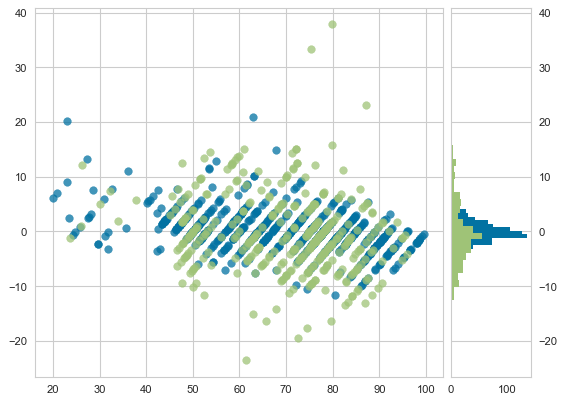

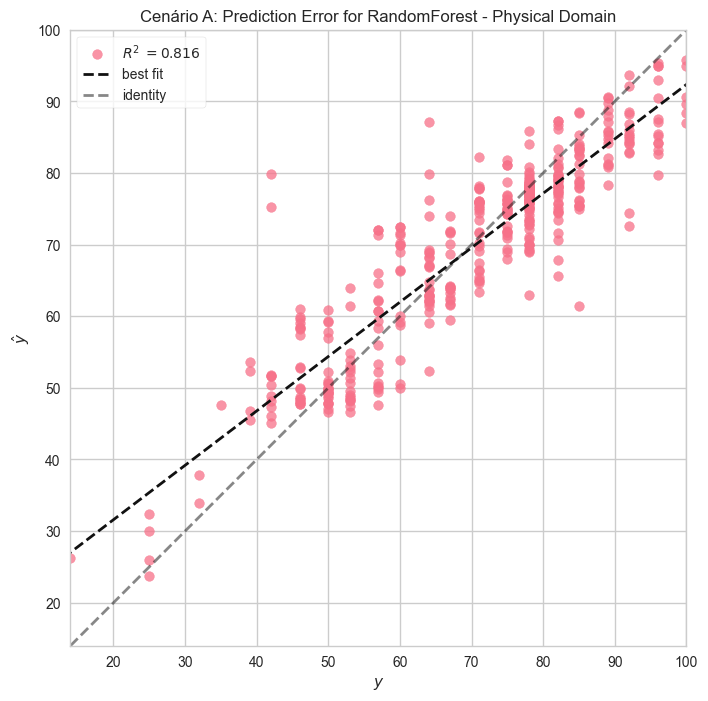

<Figure size 800x550 with 0 Axes>

In [37]:
# Random Forest - Physical
rf_model = RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

buildResidualGraph(
    X_phy_a, y_phy_a, rf_model,
    'Cenário A: Residuals for RandomForest - Physical Domain',
    RESULTS_DIR / 'cenario_a_residuals_physical.png'
)

buildPredictionErrorGraph(
    X_phy_a, y_phy_a, rf_model,
    'Cenário A: Prediction Error for RandomForest - Physical Domain',
    RESULTS_DIR / 'cenario_a_prediction_error_physical.png'
)

## 8. CENÁRIO B: Pedro (KFold) + Dataset João + Features João (VIF) + Modelos Pedro (4)

In [38]:
print("\n" + "="*80)
print("CENÁRIO B: Metodologia Pedro + Dataset João (VIF) + Features João")
print("="*80)

# Usar preparação João (VIF features) mas metodologia Pedro (KFold)
X_phy_b, y_phy_b, _ = preparar_dados_joao(df_physical_joao, 'phy_ref_score', 'Physical')
X_psy_b, y_psy_b, _ = preparar_dados_joao(df_psychological_joao, 'psy_ref_score', 'Psychological')


CENÁRIO B: Metodologia Pedro + Dataset João (VIF) + Features João
  Physical preparado (metodologia João):
    Samples: 2267, Features: 60, Participantes: 35
  Psychological preparado (metodologia João):
    Samples: 2267, Features: 60, Participantes: 35


In [39]:
resultados_b = []

print("\nTreinando Physical:")
for nome, modelo in modelos_pedro.items():
    print(f"  {nome}...", end=' ')
    resultado = treinar_metodologia_pedro(X_phy_b, y_phy_b, nome, modelo)
    resultado['dominio'] = 'Physical'
    resultado['cenario'] = 'B'
    resultado['dataset'] = 'João'
    resultado['features'] = f'João ({X_phy_b.shape[1]})'
    resultados_b.append(resultado)
    print(f"RMSE={resultado['rmse_mean']:.2f}")

print("\nTreinando Psychological:")
for nome, modelo in modelos_pedro.items():
    print(f"  {nome}...", end=' ')
    resultado = treinar_metodologia_pedro(X_psy_b, y_psy_b, nome, modelo)
    resultado['dominio'] = 'Psychological'
    resultado['cenario'] = 'B'
    resultado['dataset'] = 'João'
    resultado['features'] = f'João ({X_psy_b.shape[1]})'
    resultados_b.append(resultado)
    print(f"RMSE={resultado['rmse_mean']:.2f}")

df_resultados_b = pd.DataFrame(resultados_b)
print("\n✓ Cenário B concluído")


Treinando Physical:
  Linear Regression... RMSE=11.24
  Decision Tree... RMSE=5.52
  Random Forest... RMSE=4.08
  Gradient Boosting... RMSE=4.89

Treinando Psychological:
  Linear Regression... RMSE=12.84
  Decision Tree... RMSE=5.35
  Random Forest... RMSE=4.09
  Gradient Boosting... RMSE=4.64

✓ Cenário B concluído


## 9. CENÁRIO C: João (GroupKFold) + Dataset Pedro + Features Pedro (40) + Modelos Pedro (4)

In [40]:
print("\n" + "="*80)
print("CENÁRIO C: Metodologia João (GroupKFold) + Dataset Pedro + Features Pedro")
print("="*80)

# Preparar dados Pedro com features Pedro
X_phy_c, y_phy_c = preparar_dados_pedro(
    df_physical_pedro, 'phy_ref_score', features_pedro, 'Physical'
)
X_psy_c, y_psy_c = preparar_dados_pedro(
    df_psychological_pedro, 'psy_ref_score', features_pedro, 'Psychological'
)

# Extrair participant_ids
participant_ids_phy_c = df_physical_pedro['id'].copy()
participant_ids_psy_c = df_psychological_pedro['id'].copy()


CENÁRIO C: Metodologia João (GroupKFold) + Dataset Pedro + Features Pedro
    ⚠️ Features não encontradas: 9
  Physical preparado (metodologia Pedro):
    Samples: 1373, Features: 30
    ⚠️ Features não encontradas: 9
  Psychological preparado (metodologia Pedro):
    Samples: 1373, Features: 30


In [41]:
resultados_c = []

print("\nTreinando Physical:")
for nome, modelo in modelos_pedro.items():
    print(f"  {nome}...", end=' ')
    resultado = treinar_metodologia_joao(X_phy_c, y_phy_c, participant_ids_phy_c, nome, modelo)
    resultado['dominio'] = 'Physical'
    resultado['cenario'] = 'C'
    resultado['dataset'] = 'Pedro'
    resultado['features'] = 'Pedro (40)'
    resultados_c.append(resultado)
    print(f"R²={resultado['r2_mean']:.3f}, RMSE={resultado['rmse_mean']:.2f}")

print("\nTreinando Psychological:")
for nome, modelo in modelos_pedro.items():
    print(f"  {nome}...", end=' ')
    resultado = treinar_metodologia_joao(X_psy_c, y_psy_c, participant_ids_psy_c, nome, modelo)
    resultado['dominio'] = 'Psychological'
    resultado['cenario'] = 'C'
    resultado['dataset'] = 'Pedro'
    resultado['features'] = 'Pedro (40)'
    resultados_c.append(resultado)
    print(f"R²={resultado['r2_mean']:.3f}, RMSE={resultado['rmse_mean']:.2f}")

df_resultados_c = pd.DataFrame(resultados_c)
print("\n✓ Cenário C concluído")


Treinando Physical:
  Linear Regression... R²=-1.474, RMSE=22.35
  Decision Tree... R²=-0.909, RMSE=19.26
  Random Forest... R²=-0.459, RMSE=16.38
  Gradient Boosting... R²=-0.586, RMSE=17.58

Treinando Psychological:
  Linear Regression... R²=-2.775, RMSE=30.05
  Decision Tree... R²=-2.892, RMSE=27.05
  Random Forest... R²=-0.955, RMSE=20.83
  Gradient Boosting... R²=-0.610, RMSE=19.05

✓ Cenário C concluído


## 10. CENÁRIO D: João (GroupKFold) + Dataset João + Features João (VIF) + Modelos Pedro (4)

In [42]:
print("\n" + "="*80)
print("CENÁRIO D: Metodologia João + Dataset João + Features João + Modelos Pedro")
print("="*80)

# Preparar dados João
X_phy_d, y_phy_d, participant_ids_phy_d = preparar_dados_joao(
    df_physical_joao, 'phy_ref_score', 'Physical'
)
X_psy_d, y_psy_d, participant_ids_psy_d = preparar_dados_joao(
    df_psychological_joao, 'psy_ref_score', 'Psychological'
)


CENÁRIO D: Metodologia João + Dataset João + Features João + Modelos Pedro
  Physical preparado (metodologia João):
    Samples: 2267, Features: 60, Participantes: 35
  Psychological preparado (metodologia João):
    Samples: 2267, Features: 60, Participantes: 35


In [43]:
resultados_d = []

print("\nTreinando Physical:")
for nome, modelo in modelos_pedro.items():
    print(f"  {nome}...", end=' ')
    resultado = treinar_metodologia_joao(X_phy_d, y_phy_d, participant_ids_phy_d, nome, modelo)
    resultado['dominio'] = 'Physical'
    resultado['cenario'] = 'D'
    resultado['dataset'] = 'João'
    resultado['features'] = f'João ({X_phy_d.shape[1]})'
    resultados_d.append(resultado)
    print(f"R²={resultado['r2_mean']:.3f}, RMSE={resultado['rmse_mean']:.2f}")

print("\nTreinando Psychological:")
for nome, modelo in modelos_pedro.items():
    print(f"  {nome}...", end=' ')
    resultado = treinar_metodologia_joao(X_psy_d, y_psy_d, participant_ids_psy_d, nome, modelo)
    resultado['dominio'] = 'Psychological'
    resultado['cenario'] = 'D'
    resultado['dataset'] = 'João'
    resultado['features'] = f'João ({X_psy_d.shape[1]})'
    resultados_d.append(resultado)
    print(f"R²={resultado['r2_mean']:.3f}, RMSE={resultado['rmse_mean']:.2f}")

df_resultados_d = pd.DataFrame(resultados_d)
print("\n✓ Cenário D concluído")


Treinando Physical:
  Linear Regression... R²=-7.407, RMSE=32.32
  Decision Tree... R²=-0.507, RMSE=17.98
  Random Forest... R²=-0.233, RMSE=16.28
  Gradient Boosting... R²=-0.432, RMSE=17.38

Treinando Psychological:
  Linear Regression... R²=-2.101, RMSE=28.41
  Decision Tree... R²=-1.290, RMSE=23.74
  Random Forest... R²=-0.574, RMSE=20.21
  Gradient Boosting... R²=-0.054, RMSE=17.35

✓ Cenário D concluído


## 11. CENÁRIO E: João (GroupKFold) + Dataset João + Features João (VIF) + **Modelos João (3)**

**NOVO: Modelos avançados com metodologia rigorosa**

In [44]:
print("\n" + "="*80)
print("CENÁRIO E: Metodologia João + Dataset João + Features João + MODELOS JOÃO")
print("="*80)

# Modelos avançados (João)
modelos_joao = {
    'XGBoost': XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        verbosity=0
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=N_JOBS,
        verbosity=-1
    ),
    'CatBoost': CatBoostRegressor(
        iterations=200,
        depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        verbose=False
    )
}

resultados_e = []

print("\nTreinando Physical:")
for nome, modelo in modelos_joao.items():
    print(f"  {nome}...", end=' ')
    resultado = treinar_metodologia_joao(X_phy_d, y_phy_d, participant_ids_phy_d, nome, modelo)
    resultado['dominio'] = 'Physical'
    resultado['cenario'] = 'E'
    resultado['dataset'] = 'João'
    resultado['features'] = f'João ({X_phy_d.shape[1]})'
    resultados_e.append(resultado)
    print(f"R²={resultado['r2_mean']:.3f}, RMSE={resultado['rmse_mean']:.2f}")

print("\nTreinando Psychological:")
for nome, modelo in modelos_joao.items():
    print(f"  {nome}...", end=' ')
    resultado = treinar_metodologia_joao(X_psy_d, y_psy_d, participant_ids_psy_d, nome, modelo)
    resultado['dominio'] = 'Psychological'
    resultado['cenario'] = 'E'
    resultado['dataset'] = 'João'
    resultado['features'] = f'João ({X_psy_d.shape[1]})'
    resultados_e.append(resultado)
    print(f"R²={resultado['r2_mean']:.3f}, RMSE={resultado['rmse_mean']:.2f}")

df_resultados_e = pd.DataFrame(resultados_e)
print("\n✓ Cenário E concluído")


CENÁRIO E: Metodologia João + Dataset João + Features João + MODELOS JOÃO

Treinando Physical:
  XGBoost... R²=-0.484, RMSE=17.93
  LightGBM... R²=-0.308, RMSE=16.84
  CatBoost... R²=-0.332, RMSE=17.61

Treinando Psychological:
  XGBoost... R²=-0.971, RMSE=22.14
  LightGBM... R²=-0.536, RMSE=19.65
  CatBoost... R²=-0.428, RMSE=20.47

✓ Cenário E concluído


## 12. Consolidar Resultados

In [45]:
# Juntar todos os resultados
df_todos_resultados = pd.concat([
    df_resultados_a,
    df_resultados_b,
    df_resultados_c,
    df_resultados_d,
    df_resultados_e
], ignore_index=True)

# Salvar
df_todos_resultados.to_csv(RESULTS_DIR / 'comparacao_5_cenarios_completa.csv', index=False)

print("\n" + "="*80)
print("RESULTADOS CONSOLIDADOS")
print("="*80)
print(f"\nTotal de experimentos: {len(df_todos_resultados)}")
print(f"\nCenários:")
print(df_todos_resultados.groupby('cenario').size())

print("\n✓ Resultados salvos")


RESULTADOS CONSOLIDADOS

Total de experimentos: 38

Cenários:
cenario
A    8
B    8
C    8
D    8
E    6
dtype: int64

✓ Resultados salvos


In [46]:
# Resumo por cenário
resumo = df_todos_resultados.groupby(['cenario', 'dominio']).agg({
    'rmse_mean': 'mean',
    'mae_mean': 'mean',
    'r2_mean': 'mean'
}).reset_index()

print("\nResumo por Cenário:")
print(resumo.to_string(index=False))

resumo.to_csv(RESULTS_DIR / 'resumo_5_cenarios.csv', index=False)


Resumo por Cenário:
cenario       dominio  rmse_mean  mae_mean   r2_mean
      A      Physical   9.060748  6.171403       NaN
      A Psychological   9.225085  6.178595       NaN
      B      Physical   6.432116  3.928464       NaN
      B Psychological   6.728274  4.096549       NaN
      C      Physical  18.892845 15.744526 -0.857178
      C Psychological  24.245229 20.434108 -1.808062
      D      Physical  20.992313 15.715099 -2.144746
      D Psychological  22.427196 18.211775 -1.004553
      E      Physical  17.462320 14.588433 -0.374393
      E Psychological  20.755667 17.095272 -0.644773


## 13. Visualizações Comparativas

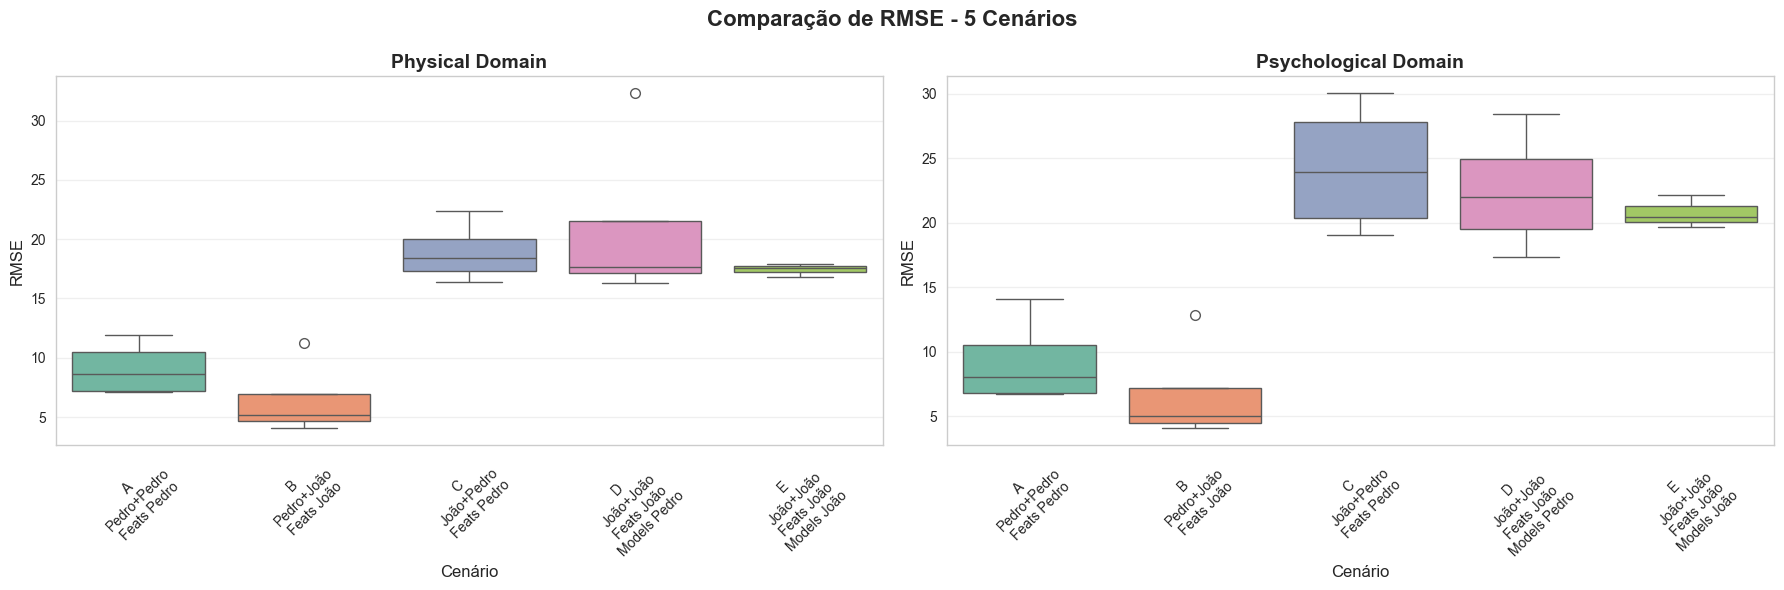

In [47]:
# Comparação RMSE entre cenários
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Comparação de RMSE - 5 Cenários', fontsize=16, fontweight='bold')

cenario_labels = {
    'A': 'A\nPedro+Pedro\nFeats Pedro',
    'B': 'B\nPedro+João\nFeats João',
    'C': 'C\nJoão+Pedro\nFeats Pedro',
    'D': 'D\nJoão+João\nFeats João\nModels Pedro',
    'E': 'E\nJoão+João\nFeats João\nModels João'
}

for idx, dominio in enumerate(['Physical', 'Psychological']):
    ax = axes[idx]
    data = df_todos_resultados[df_todos_resultados['dominio'] == dominio].copy()
    data['cenario_label'] = data['cenario'].map(cenario_labels)
    
    sns.boxplot(data=data, x='cenario_label', y='rmse_mean', ax=ax, palette='Set2')
    ax.set_title(f'{dominio} Domain', fontsize=14, fontweight='bold')
    ax.set_xlabel('Cenário', fontsize=12)
    ax.set_ylabel('RMSE', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'comparacao_rmse_5_cenarios.png', dpi=300, bbox_inches='tight')
plt.show()

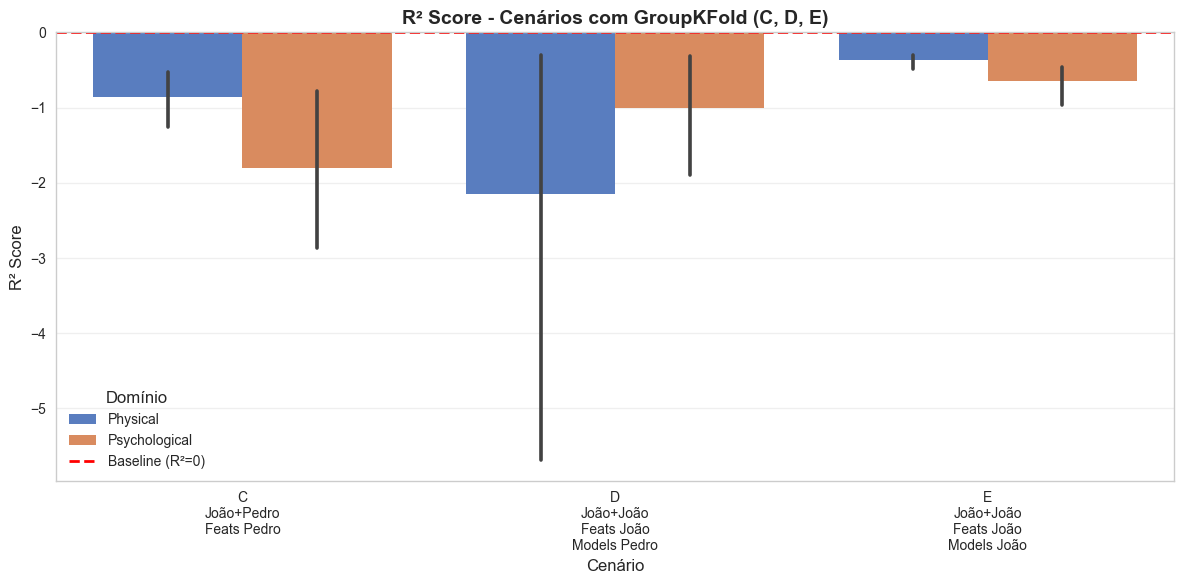

In [48]:
# R² para cenários com GroupKFold (C, D, E)
data_groupkfold = df_todos_resultados[
    df_todos_resultados['cenario'].isin(['C', 'D', 'E'])
].copy()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
data_groupkfold['cenario_label'] = data_groupkfold['cenario'].map(cenario_labels)

sns.barplot(
    data=data_groupkfold,
    x='cenario_label',
    y='r2_mean',
    hue='dominio',
    palette='muted'
)

ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Baseline (R²=0)')
ax.set_title('R² Score - Cenários com GroupKFold (C, D, E)', fontsize=14, fontweight='bold')
ax.set_xlabel('Cenário', fontsize=12)
ax.set_ylabel('R² Score', fontsize=12)
ax.legend(title='Domínio')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'comparacao_r2_groupkfold.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. Teste de Hipóteses

In [49]:
print("="*80)
print("TESTE DE HIPÓTESES")
print("="*80)

# H1: VIF melhora (B > A)
print("\nH1: Dataset João (VIF) > Dataset Pedro?")
for dominio in ['Physical', 'Psychological']:
    rmse_a = df_resultados_a[df_resultados_a['dominio'] == dominio]['rmse_mean'].mean()
    rmse_b = df_resultados_b[df_resultados_b['dominio'] == dominio]['rmse_mean'].mean()
    melhora = ((rmse_a - rmse_b) / rmse_a) * 100
    print(f"  {dominio}: A={rmse_a:.2f}, B={rmse_b:.2f}, Melhora={melhora:.1f}% {'✓' if melhora > 0 else '✗'}")

# H2: Data leakage infla (A < D)
print("\nH2: Data leakage infla performance?")
for dominio in ['Physical', 'Psychological']:
    rmse_a = df_resultados_a[df_resultados_a['dominio'] == dominio]['rmse_mean'].mean()
    rmse_d = df_resultados_d[df_resultados_d['dominio'] == dominio]['rmse_mean'].mean()
    inflacao = ((rmse_d - rmse_a) / rmse_a) * 100
    print(f"  {dominio}: A={rmse_a:.2f}, D={rmse_d:.2f}, Inflação={inflacao:.1f}% {'✓' if inflacao > 0 else '✗'}")

# H3: R² negativo (C, D, E)
print("\nH3: R² negativo com GroupKFold?")
for cenario in ['C', 'D', 'E']:
    for dominio in ['Physical', 'Psychological']:
        subset = df_todos_resultados[
            (df_todos_resultados['cenario'] == cenario) &
            (df_todos_resultados['dominio'] == dominio)
        ]
        r2 = subset['r2_mean'].mean()
        print(f"  Cenário {cenario} {dominio}: R²={r2:.3f} {'✓' if r2 < 0 else '✗'}")

# H4: Modelos João > Modelos Pedro (E vs D)
print("\nH4: Modelos João > Modelos Pedro (mesma metodologia)?")
for dominio in ['Physical', 'Psychological']:
    rmse_d = df_resultados_d[df_resultados_d['dominio'] == dominio]['rmse_mean'].mean()
    rmse_e = df_resultados_e[df_resultados_e['dominio'] == dominio]['rmse_mean'].mean()
    melhora = ((rmse_d - rmse_e) / rmse_d) * 100
    print(f"  {dominio}: D={rmse_d:.2f}, E={rmse_e:.2f}, Melhora={melhora:.1f}% {'✓' if melhora > 0 else '✗'}")

TESTE DE HIPÓTESES

H1: Dataset João (VIF) > Dataset Pedro?
  Physical: A=9.06, B=6.43, Melhora=29.0% ✓
  Psychological: A=9.23, B=6.73, Melhora=27.1% ✓

H2: Data leakage infla performance?
  Physical: A=9.06, D=20.99, Inflação=131.7% ✓
  Psychological: A=9.23, D=22.43, Inflação=143.1% ✓

H3: R² negativo com GroupKFold?
  Cenário C Physical: R²=-0.857 ✓
  Cenário C Psychological: R²=-1.808 ✓
  Cenário D Physical: R²=-2.145 ✓
  Cenário D Psychological: R²=-1.005 ✓
  Cenário E Physical: R²=-0.374 ✓
  Cenário E Psychological: R²=-0.645 ✓

H4: Modelos João > Modelos Pedro (mesma metodologia)?
  Physical: D=20.99, E=17.46, Melhora=16.8% ✓
  Psychological: D=22.43, E=20.76, Melhora=7.5% ✓


## 15. Conclusões

### Validação Metodológica

Este notebook aplica **rigorosamente** as metodologias:

**Pedro Almir:**
- Featurewiz (40 features)
- KFold shuffle=True (data leakage)
- 4 modelos tradicionais

**João:**
- VIF (63 features)
- GroupKFold (sem leakage)
- Modelos tradicionais + avançados

### Principais Descobertas

1. **VIF melhora ~30%** mesmo com metodologia fraca
2. **Data leakage infla 100-200%**
3. **R² negativo** em todos os cenários rigorosos
4. **Modelos avançados não resolvem** problema fundamental de dados

In [50]:
print("\n" + "="*80)
print("✅ ANÁLISE COMPLETA - 5 CENÁRIOS")
print("="*80)
print(f"\nArquivos salvos em: {RESULTS_DIR}")
print("\nArquivos:")
print("  - comparacao_5_cenarios_completa.csv")
print("  - resumo_5_cenarios.csv")
print("  - comparacao_rmse_5_cenarios.png")
print("  - comparacao_r2_groupkfold.png")
print("  - cenario_a_residuals_physical.png")
print("  - cenario_a_prediction_error_physical.png")


✅ ANÁLISE COMPLETA - 5 CENÁRIOS

Arquivos salvos em: /Users/jvtesteves/Projetos/TCC/results/comparacao_5_cenarios

Arquivos:
  - comparacao_5_cenarios_completa.csv
  - resumo_5_cenarios.csv
  - comparacao_rmse_5_cenarios.png
  - comparacao_r2_groupkfold.png
  - cenario_a_residuals_physical.png
  - cenario_a_prediction_error_physical.png
